# Importing Libraries

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading the training data

In [160]:
df = pd.read_csv("X_train.csv")

# 1. Setting the Baseline

## 1.1 Data Preparation and Validation Pipeline

### Trajectories

In [161]:
df["T"] = np.ceil((df["Id"]+1) / 257)
df.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,T
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0,1.0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1,1.0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2,1.0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3,1.0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4,1.0


### Validation of null values

In [163]:
print(df.isnull().sum())
print(f"Dados nulos: {df.isnull().sum().sum()}")

t        0
x_1      0
y_1      0
v_x_1    0
v_y_1    0
x_2      0
y_2      0
v_x_2    0
v_y_2    0
x_3      0
y_3      0
v_x_3    0
v_y_3    0
Id       0
T        0
dtype: int64
Dados nulos: 0


### Plot the trajectories

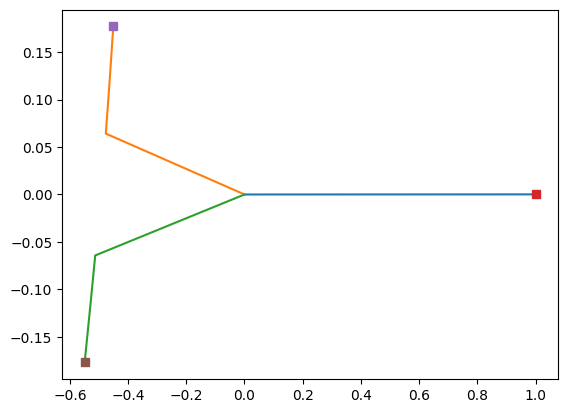

In [164]:
sample = df[df["T"] == 3]

plt.plot(sample.x_1, sample.y_1)
plt.plot(sample.x_2, sample.y_2)
plt.plot(sample.x_3, sample.y_3)

plt.plot(sample.x_1.to_numpy()[0], sample.y_1.to_numpy()[0], 's')
plt.plot(sample.x_2.to_numpy()[0], sample.y_2.to_numpy()[0], 's')
plt.plot(sample.x_3.to_numpy()[0], sample.y_3.to_numpy()[0], 's')

### Drop of non-features and collisions

In [165]:
df = df.drop(["v_x_1", "v_y_1", "v_x_2", "v_y_2", "v_x_3", "v_y_3"], axis = 1)
print(df.shape)
df = df[~((df.x_1 == 0) & (df.y_1 == 0) & (df.x_2 == 0) & (df.y_2 == 0) & (df.x_3 == 0) & (df.y_3 == 0))]
print(df.shape)

(1285000, 9)
(1089790, 9)


### Divide data in train/val/test

In [166]:
initial_pos = df.copy()
initial_pos["n_repeats"] = initial_pos.groupby("T", as_index=False)["T"].transform('count')
initial_pos = initial_pos[initial_pos['t']==0].reset_index(drop = True)

# Optimized generate_rows function
def generate_rows(row):
    n = int(row['n_repeats'])
    
    # Use numpy to generate t values and repeat other values efficiently
    t_values = np.linspace(0, 10, n)
    
    # Create arrays for each column that needs to be repeated
    repeated_data = {
        't': t_values,
        'x_1': np.repeat(row['x_1'], n),
        'y_1': np.repeat(row['y_1'], n),
        'x_2': np.repeat(row['x_2'], n),
        'y_2': np.repeat(row['y_2'], n),
        'x_3': np.repeat(row['x_3'], n),
        'y_3': np.repeat(row['y_3'], n),
        'Id': np.arange(n),  # Incremental Id
        'T': np.repeat(row['T'], n)
    }
    
    return pd.DataFrame(repeated_data)

# Generate new rows for each row in the DataFrame based on n_repeats
X = pd.concat([generate_rows(row) for _, row in initial_pos.iterrows()], ignore_index=True)
X = X[X["t"] != 0].reset_index(drop = True)

In [167]:
non_initial_pos = df.copy()
non_initial_pos = non_initial_pos[non_initial_pos['t']!=0].reset_index(drop = True)
y = non_initial_pos.copy()

In [168]:
X.shape[0] == y.shape[0]

True

In [169]:
rows = X.shape[0]
train_rows = np.ceil(rows*0.6)
val_rows = np.ceil(train_rows + rows*0.2)
test_rows = np.ceil(val_rows + rows*0.2)

_X_train, _y_train = X.loc[:train_rows-1].reset_index(drop = True),  y.loc[:train_rows-1].reset_index(drop = True)
_X_val, _y_val     = X.loc[train_rows:val_rows-1].reset_index(drop = True),  y.loc[train_rows:val_rows-1].reset_index(drop = True)
_X_test, _y_test   = X.loc[val_rows:test_rows].reset_index(drop = True),  y.loc[val_rows:test_rows].reset_index(drop = True)

def split_data(X:pd.DataFrame, y:pd.DataFrame, sample_percentage:float = 1):
    
    rows = X.shape[0]
    rows = round(rows*sample_percentage,0)

    X = X.loc[:rows]
    y = y.loc[:rows]

    X, y = X[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', "t"]], y[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

    return X, y

### Define Sample Percentagem to use in train/val/test

In [170]:
SAMPLE_PERC = 0.1

X_train, y_train = split_data(_X_train, _y_train, sample_percentage=SAMPLE_PERC)
X_val  , y_val   = split_data(_X_val  , _y_val  , sample_percentage=SAMPLE_PERC)
X_test , y_test  = split_data(_X_test , _y_test , sample_percentage=SAMPLE_PERC)

## 1.2 Learn the baseline model

In [171]:
def baseline(X_train, y_train, X_val, y_val):
    #pipeline with a StandardScaler and LinearRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    #Train the model
    pipeline.fit(X_train, y_train)

    #Predict on the train data
    y_pred_train = pipeline.predict(X_train)

    #Predict on the validation data
    y_val_pred = pipeline.predict(X_val)

    #Mean squared error
    rmse_train = root_mean_squared_error(y_train,y_pred_train)
    print(rmse_train)

    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    print(rmse_val)

    return y_pred_train, y_val_pred

def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    y_val = y_val.to_numpy()
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()


1.395568528112933
1.3704864315553873


### Baseline Results

In [ ]:
y_pred_train_b, y_val_pred_b = baseline(X_train, y_train, X_val, y_val)

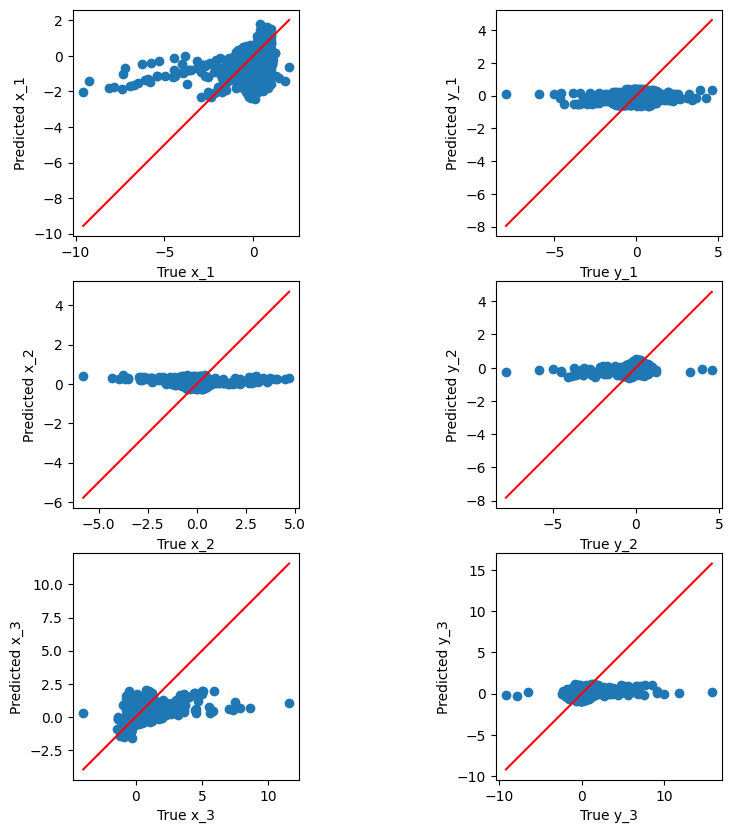

In [172]:
plot_y_yhat(y_val,y_val_pred_b,plot_title = f"baseline_{SAMPLE_PERC}_percent")

# 2. Nonlinear models on the data — the Polynomial Regression model

## 2.1 Development

In [173]:

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None, plot_title="Polynomial_Regression"):

    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0

    train_rmses, val_rmses = [], []

    for i in degrees:
        
        poly = PolynomialFeatures(degree=i)

        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        
        print(f"fitting degree {i} with {poly.n_output_features_} features...")

        regressor.fit(X_train_poly, y_train)
        
        y_train_pred = regressor.predict(X_train_poly)

        y_val_pred = regressor.predict(X_val_poly)

        #Mean squared error
        rmse_poly_train = root_mean_squared_error(y_train,y_train_pred)
        train_rmses.append(rmse_poly_train)
        print(rmse_poly_train)

        rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
        val_rmses.append(rmse_poly_val)
        print(rmse_poly_val)

        if rmse_poly_val < best_val_rmse:
            best_regressor = regressor
            best_val_rmse = rmse_poly_val
            best_degree = i
            best_poly_features = poly  # Save the best polynomial features transformer

        print("")
        
    plt.plot(degrees, train_rmses, color='blue')
    plt.plot(degrees, val_rmses, color='red')
    plt.legend(['train', 'val'])
    plt.xlabel('degrees')
    plt.ylabel('RMSE')
    plt.show()

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")
        
    # Use the best model to predict on validation set
    best_X_train_poly = best_poly_features.transform(X_train)  # Transform validation set using best degree
    best_X_val_poly = best_poly_features.transform(X_val)  # Transform validation set using best degree
    best_regressor.fit(best_X_train_poly, y_train)
    best_y_val_pred = best_regressor.predict(best_X_val_poly)  # Predictions using the best model

    plot_y_yhat(y_val, best_y_val_pred, plot_title=plot_title)

    return best_regressor, best_val_rmse, best_degree


## 2.2 Evaluation

### StandardScaler with Ridge

In [174]:
# regressor = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', Ridge())
# ])

# best_regressor, best_val_rmse, best_degree = validate_poly_regression(X_train, y_train, X_val, y_val, regressor=regressor, degrees=range(1,10), max_features=None, plot_title=f"Poly_Regression_Ridge")

### StandarScaler with RidgeCV

In [175]:
# regressor = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', RidgeCV())
# ])

# best_regressor, best_val_rmse, best_degree = validate_poly_regression(X_train, y_train, X_val, y_val, regressor=regressor, degrees=range(1,8), max_features=None, plot_title=f"Poly_Regression_Ridge_CV")

# 3. Feature Enginnering

## 3.1 Removing Features

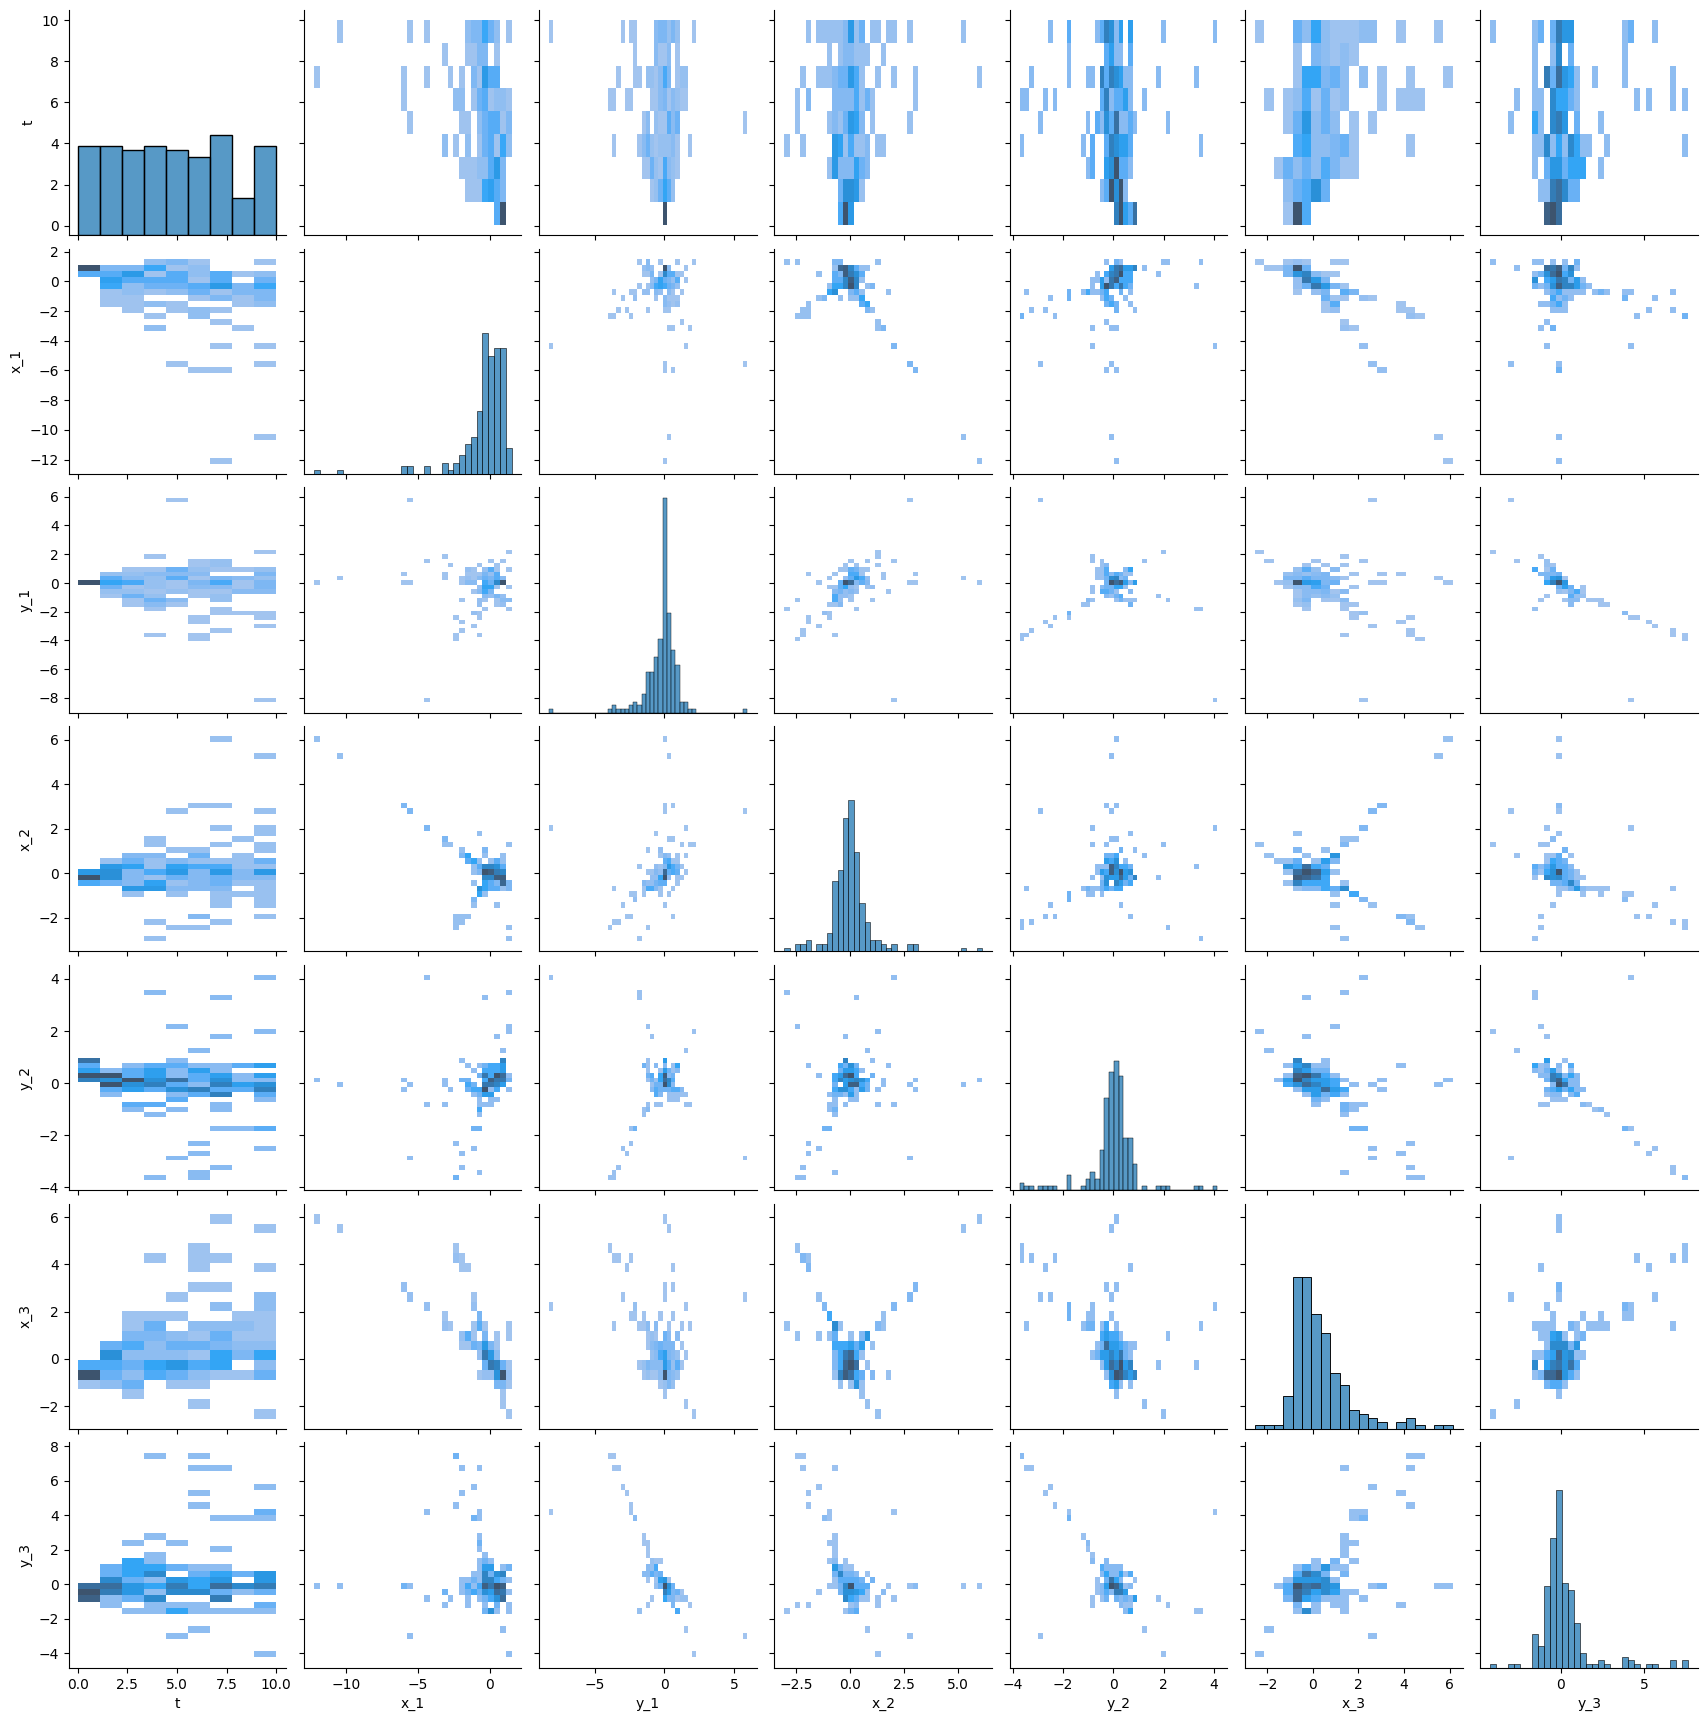

In [176]:
sns.pairplot(df.drop(["Id", "T"], axis = 1).sample(200), kind="hist")

<Axes: >

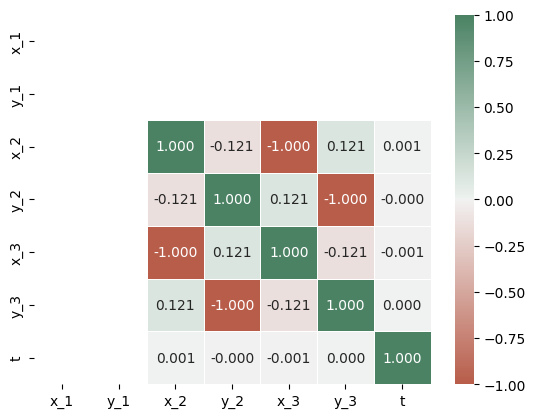

In [177]:
import seaborn as sns
corr = X_train.corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

<Axes: >

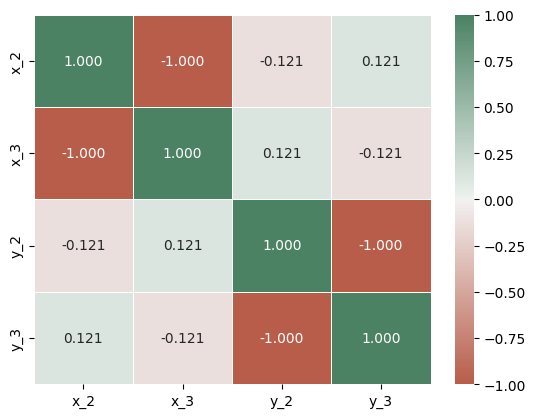

In [178]:
corr = X_train[["x_2", "x_3", "y_2", "y_3"]].corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

In [179]:
y_pred_train_b, y_val_pred_b = baseline(
    X_train,
    y_train,
    X_val,
    y_val
)

1.395568528112933
1.3704864315553873


1.395568786497222
1.3704959161555472


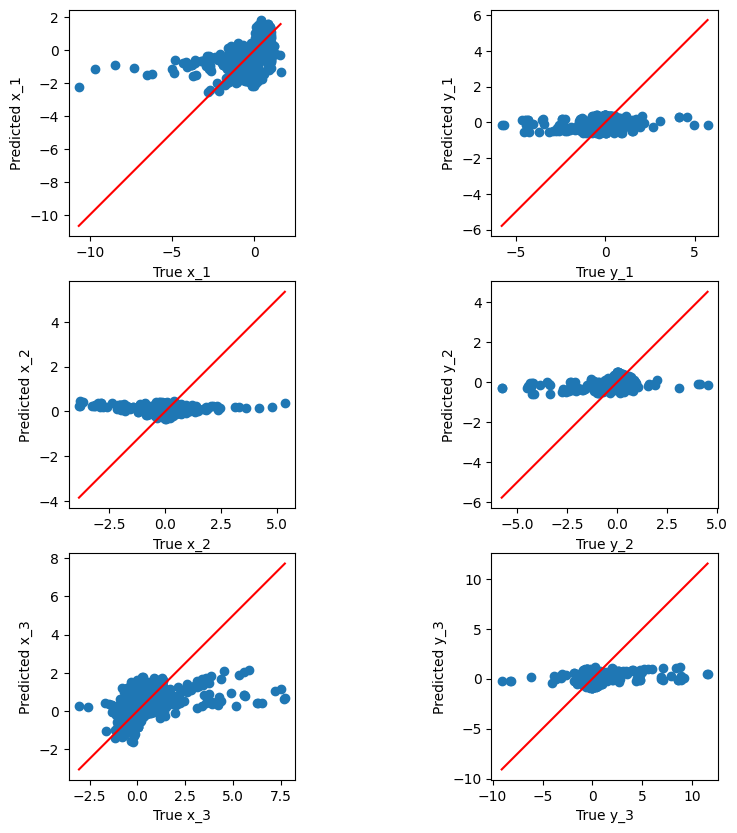

In [180]:
y_pred_train_b, y_val_pred_b = baseline(
    X_train.drop(["x_1", "y_1"], axis = 1),
    y_train,
    X_val.drop(["x_1", "y_1"], axis = 1),
    y_val)
plot_y_yhat(y_val,y_val_pred_b,plot_title = f"baseline_drop_x1_y1_{SAMPLE_PERC}_percent")

1.395583145753954
1.370292289870747


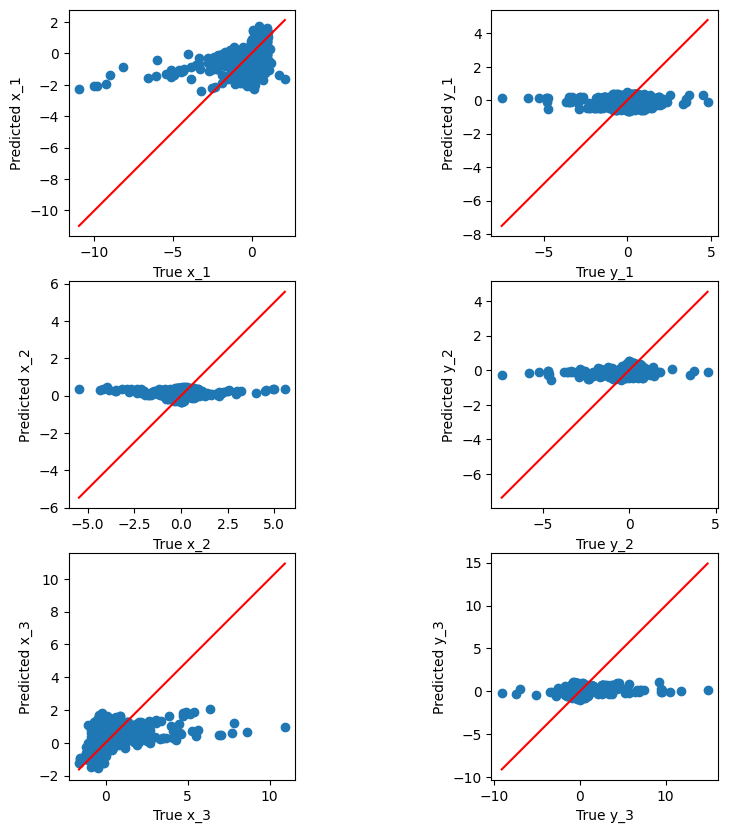

In [181]:
y_pred_train_b, y_val_pred_b = baseline(
    X_train.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1),
    y_train,
    X_val.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1),
    y_val)
plot_y_yhat(y_val,y_val_pred_b,plot_title = f"baseline_drop_x1_3_y1_3_{SAMPLE_PERC}_percent")

## 3.2 Evaluation of Variable Reduction

In [182]:
# regressor = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', RidgeCV())
# ])

# best_regressor, best_val_rmse, best_degree = validate_poly_regression(
#     X_train.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1), 
#     y_train, 
#     X_val.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1), 
#     y_val, regressor=regressor, degrees=range(1,8), max_features=None, plot_title=f"Poly_Regression_Ridge_CV")

## 3.3 Adding Variables

### Feature Relative Angles between points

In [183]:
def feature_relative_angle(data):
    # Vectorized calculation of the relative angles between the three bodies using pandas
    # Compute the vectors for body pairs
    vector_12_x = data['x_2'] - data['x_1']
    vector_12_y = data['y_2'] - data['y_1']

    vector_13_x = data['x_3'] - data['x_1']
    vector_13_y = data['y_3'] - data['y_1']

    # Dot product between vectors (body 1-2 and body 1-3)
    dot_product = vector_12_x * vector_13_x + vector_12_y * vector_13_y

    # Magnitudes of the vectors
    magnitude_12 = np.sqrt(vector_12_x**2 + vector_12_y**2)
    magnitude_13 = np.sqrt(vector_13_x**2 + vector_13_y**2)

    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_12 * magnitude_13)

    # Calculate the angle in degrees using arccos
    data['angle_1_2_3'] = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    # # Display the updated dataframe with angles using optimized pandas calculations
    # tools.display_dataframe_to_user(name="Optimized Three-Body Problem with Angles", dataframe=data)

    return data

def feature_relative_angle_2(data):
    # Vectorized calculation of the relative angles between the three bodies using pandas
    # Compute the vectors for body pairs
    vector_21_x = data['x_1'] - data['x_2']
    vector_21_y = data['y_1'] - data['y_2']

    vector_23_x = data['x_3'] - data['x_2']
    vector_23_y = data['y_3'] - data['y_2']

    # Dot product between vectors (body 1-2 and body 1-3)
    dot_product = vector_21_x * vector_23_x + vector_21_y * vector_23_y

    # Magnitudes of the vectors
    magnitude_12 = np.sqrt(vector_21_x**2 + vector_21_y**2)
    magnitude_13 = np.sqrt(vector_23_x**2 + vector_23_y**2)

    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_12 * magnitude_13)

    # Calculate the angle in degrees using arccos
    data['angle_2_1_3'] = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    # # Display the updated dataframe with angles using optimized pandas calculations
    # tools.display_dataframe_to_user(name="Optimized Three-Body Problem with Angles", dataframe=data)

    return data

def feature_relative_angle_3(data):
    
    # Calculate the angle in degrees using arccos
    data['angle_3_1_2'] = 3.14159-data['angle_2_1_3']-data['angle_1_2_3']

    # # Display the updated dataframe with angles using optimized pandas calculations
    # tools.display_dataframe_to_user(name="Optimized Three-Body Problem with Angles", dataframe=data)

    return data

X_train = feature_relative_angle(X_train)
X_val = feature_relative_angle(X_val)
X_test = feature_relative_angle(X_test)

X_train = feature_relative_angle_2(X_train)
X_val = feature_relative_angle_2(X_val)
X_test = feature_relative_angle_2(X_test)

X_train = feature_relative_angle_3(X_train)
X_val = feature_relative_angle_3(X_val)
X_test = feature_relative_angle_3(X_test)

1.3754775098935277
1.3826118706884554


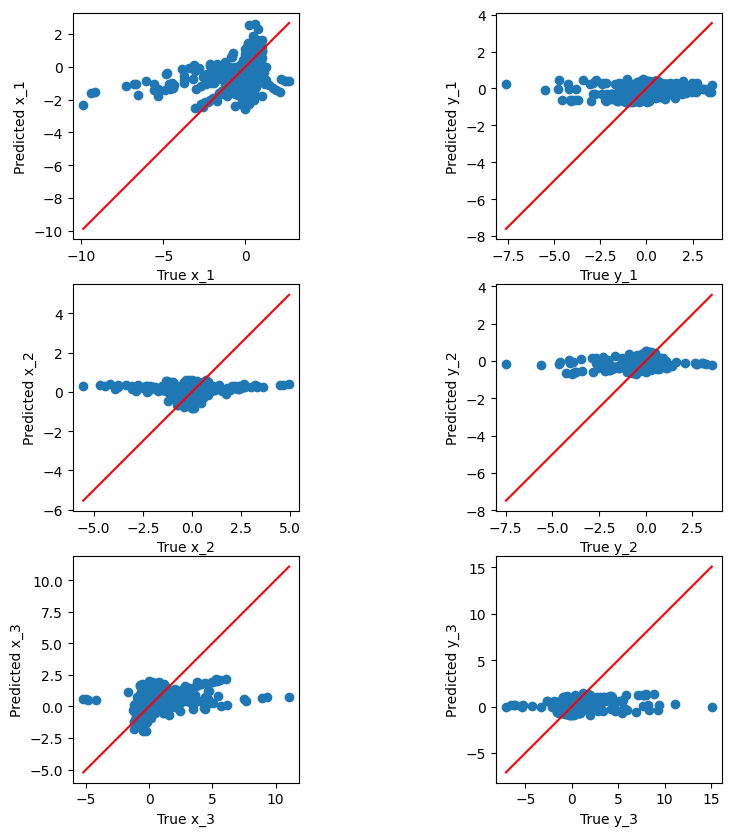

In [184]:
y_pred_train_b, y_val_pred_b = baseline(
    X_train.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1),
    y_train,
    X_val.drop(["x_1", "y_1", "x_3", "y_3"], axis = 1),
    y_val)
plot_y_yhat(y_val,y_val_pred_b,plot_title = f"baseline_angles_features_{SAMPLE_PERC}_percent")

<Axes: >

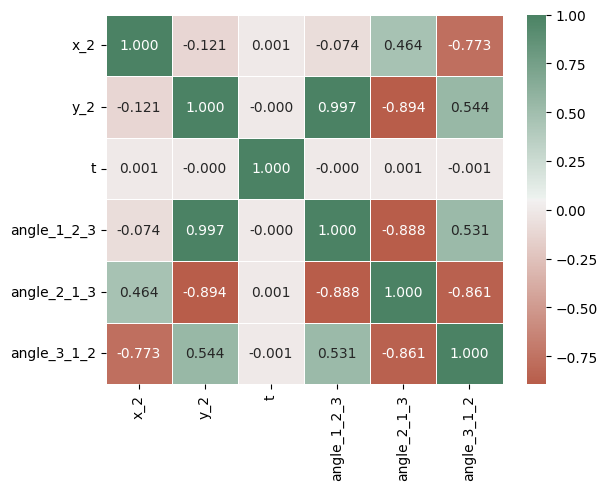

In [185]:
corr = X_train.drop(["x_1", 'y_1', 'x_3', 'y_3'], axis = 1).corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

<Axes: >

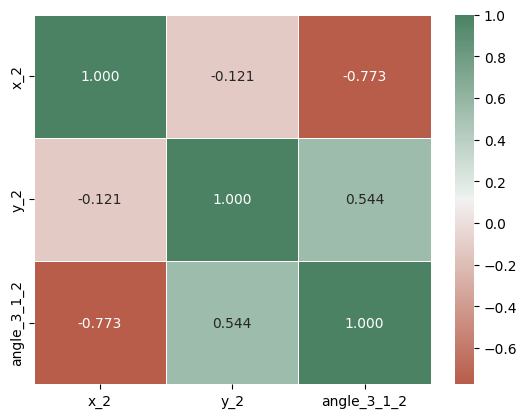

In [186]:
corr = X_train.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 'angle_2_1_3', 't'], axis = 1).corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

#### Evaluation after adding angles

In [187]:
# regressor = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', RidgeCV())
# ])

# best_regressor, best_val_rmse, best_degree = validate_poly_regression(
#     X_train.drop(["x_1", "y_1", "x_3", "y_3", 'angle_1_2_3', 'angle_2_1_3', 't'], axis = 1), 
#     y_train, 
#     X_val.drop(["x_1", "y_1", "x_3", "y_3", 'angle_1_2_3', 'angle_2_1_3', 't'], axis = 1), 
#     y_val, regressor=regressor, degrees=range(1,8), max_features=None, plot_title=f"Poly_Regression_Angles_Ridge_CV")

### Feature Distance Between Points

In [189]:
def distance_between_points(df):

    data = df.copy()
    # Calculate the Euclidean distance between each pair of bodies
    data['distance_1_2'] = np.sqrt((data['x_1'] - data['x_2'])**2 + (data['y_1'] - data['y_2'])**2)
    data['distance_1_3'] = np.sqrt((data['x_1'] - data['x_3'])**2 + (data['y_1'] - data['y_3'])**2)
    data['distance_2_3'] = np.sqrt((data['x_2'] - data['x_3'])**2 + (data['y_2'] - data['y_3'])**2)

    return data

In [190]:
X_train = distance_between_points(X_train)
X_val = distance_between_points(X_val)
X_test = distance_between_points(X_test)

<Axes: >

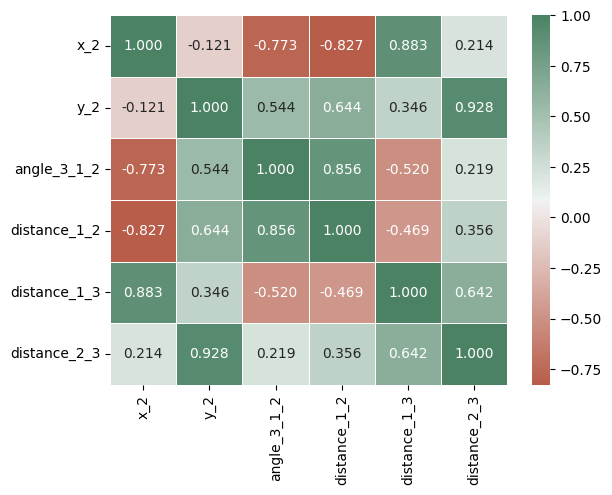

In [191]:
corr = X_train.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 'angle_2_1_3', 't'], axis = 1).corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

<Axes: >

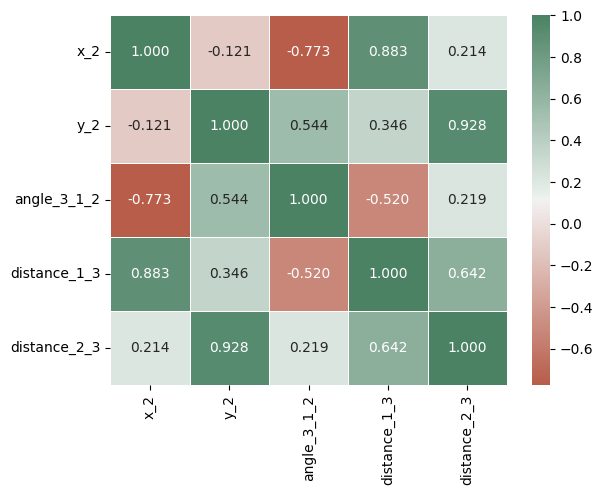

In [192]:
corr = X_train.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 'angle_2_1_3', 't', 'distance_1_2'], axis = 1).corr()
sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr,annot=True, fmt=".3f",linewidth=.5,cmap=sns.diverging_palette(20, 145, s=60, as_cmap=True))

#### Evaluation after adding distance

In [193]:
# regressor = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', RidgeCV())
# ])

# best_regressor, best_val_rmse, best_degree = validate_poly_regression(
#     X_train.drop(["x_1", "y_1", "x_3", "y_3", 'angle_1_2_3', 'angle_2_1_3', 't', 'distance_1_2'], axis = 1), 
#     y_train, 
#     X_val.drop(["x_1", "y_1", "x_3", "y_3", 'angle_1_2_3', 'angle_2_1_3', 't', 'distance_1_2'], axis = 1), 
#     y_val, regressor=regressor, degrees=range(1,8), max_features=None, plot_title=f"Poly_Regression_Angles_Ridge_CV")

## 3.4 Evaluation of Variable Augmentation

#### Best model with angles against **Test Dataset**

In [188]:
# best_regressor.fit(best_poly_features.fit_transform(X_train.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 't', 'angle_2_1_3'], axis = 1)), y_train)
# y_test_pred_poly = best_regressor.predict(best_poly_features.transform(X_test.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 't', 'angle_2_1_3'], axis = 1)))
# rmse_poly_test = root_mean_squared_error(y_test, y_test_pred_poly)
# print(rmse_poly_test)

#### Best model with distances against **Test Dataset**

In [194]:
# best_regressor.fit(best_poly_features.fit_transform(X_train.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 't', 'angle_2_1_3', 'distance_1_2'], axis = 1)), y_train)
# y_test_pred_poly = best_regressor.predict(best_poly_features.transform(X_test.drop(["x_1", 'y_1', 'x_3', 'y_3', 'angle_1_2_3', 't', 'angle_2_1_3', 'distance_1_2'], axis = 1)))
# rmse_poly_test = root_mean_squared_error(y_test, y_test_pred_poly)
# print(rmse_poly_test)

# 4. Nonparametric Model - The k-Nearest Neighbors Regressor

## 4.1 Development

In [195]:
from sklearn.preprocessing import Normalizer
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,21)):

    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0
    train_rmses, val_rmses = [], []

    scale =  Normalizer()
    X_train = scale.fit_transform(X_train)
    X_val = scale.fit_transform(X_val)
    for k_neigh in k:
        print(f"Running kNN with {k_neigh} neighbors...")
        # regressor = Pipeline([
        # ('scaler', StandardScaler()),
        # ('regressor', KNeighborsRegressor(n_neighbors=k_neigh, n_jobs=-1))
        # ])

        knn = KNeighborsRegressor(n_neighbors=k_neigh, weights='distance')
        
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        y_val_pred = knn.predict(X_val)

        #Mean squared error
        rmse_poly_train = root_mean_squared_error(y_train, y_train_pred)
        train_rmses.append(rmse_poly_train)
        print(rmse_poly_train)

        rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
        val_rmses.append(rmse_poly_val)
        print(rmse_poly_val)
        print("")
        if rmse_poly_val < best_val_rmse:
            best_regressor = knn
            best_val_rmse = rmse_poly_val
            best_degree = k_neigh

    print("")

    plt.plot(k, train_rmses, color='blue')
    plt.plot(k, val_rmses, color='red')
    plt.legend(['train', 'val'])
    plt.xlabel('degrees')
    plt.ylabel('RMSE')
    plt.show()

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")

    return best_regressor

In [196]:
columns = [
    # 'x_1', 
    # 'y_1', 
    'x_2', 
    'y_2', 
    # 'x_3', 
    # 'y_3', 
    't', 
    # 'angle_1_2_3', 
    # 'angle_2_1_3', 
    'angle_3_1_2', 
    'distance_1_2', 
    'distance_1_3', 
    'distance_2_3'
    ]

## 4.2 Evaluation

In [197]:
# regressor = validate_knn_regression(X_train[columns],
#                         y_train,
#                         X_val[columns],
#                         y_val,
#                         range(51,52))

In [198]:
# scale = Normalizer()
# y_test_pred_poly = regressor.predict(scale.fit_transform(X_test[columns]))
# rmse_poly_test = root_mean_squared_error(y_test, y_test_pred_poly)
# print(rmse_poly_test)

# 5. Other Ideas

## 5.1 Knn with centroid

In [199]:
def centroid(data):

    df = data.copy()
    # Calculate the Euclidean distance between each pair of bodies
    df['centroid_x'] = (df['x_1'] + df['x_2'] + df["x_3"])/3
    df['centroid_y'] = (df['y_1'] + df['y_2'] + df["y_3"])/3

    return df

X_train = centroid(X_train)
X_val   = centroid(X_val)

In [200]:
def validate_new_knn_strategy(X_train, y_train, X_val, y_val, k=range(1,21)):

    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0
    train_rmses, val_rmses = [], []

    scale =  Normalizer()
    X_train = scale.fit_transform(X_train)
    X_val = scale.fit_transform(X_val)
    
    for k_neigh in k:
        print(f"Running kNN with {k_neigh} neighbors...")
        
        knn = KNeighborsRegressor(n_neighbors=k_neigh, weights='distance')
        
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        y_val_pred = knn.predict(X_val)

        #Mean squared error
        rmse_poly_train = root_mean_squared_error(y_train, y_train_pred)
        train_rmses.append(rmse_poly_train)
        print(rmse_poly_train)

        rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
        val_rmses.append(rmse_poly_val)
        print(rmse_poly_val)
        print("")
        if rmse_poly_val < best_val_rmse:
            best_regressor = knn
            best_val_rmse = rmse_poly_val
            best_degree = k_neigh

    print("")

    plt.plot(k, train_rmses, color='blue')
    plt.plot(k, val_rmses, color='red')
    plt.legend(['train', 'val'])
    plt.xlabel('degrees')
    plt.ylabel('RMSE')
    plt.show()

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")

    return best_regressor

columns = [
    # 'x_1', 
    # 'y_1', 
    'x_2', 
    'y_2', 
    # 'x_3', 
    # 'y_3', 
    't', 
    'angle_1_2_3', 
    # 'angle_2_1_3', 
    'angle_3_1_2', 
    # 'distance_1_2', 
    # 'distance_1_3', 
    # 'distance_2_3',
    'centroid_x'
    ]

# regressor = validate_new_knn_strategy(X_train[columns],
#                         y_train,
#                         X_val[columns],
#                         y_val,
#                         range(35,55,1))

In [201]:
# X_test   = centroid(X_test)
# scale = Normalizer()
# y_test_pred_poly = regressor.predict(scale.fit_transform(X_test[columns]))
# rmse_poly_test = root_mean_squared_error(y_test, y_test_pred_poly)
# print(rmse_poly_test)

## 5.2 GradientBoostingClassifier

In [225]:
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

def validate_gbc(X_train, y_train, X_val, y_val):
    
    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0
    train_rmses, val_rmses = [], []

    scale =  Normalizer()
    X_train = scale.fit_transform(X_train)
    X_val = scale.fit_transform(X_val)

    # Define the hyperparameter grid for HistGradientBoostingRegressor
    param_grid = {
        'estimator__learning_rate': [0.01, 0.1, 0.2],      # Learning rate of the boosting process
        'estimator__max_iter': [100, 200, 300],            # Number of boosting iterations
        'estimator__max_depth': [3, 5, None],              # Maximum depth of the trees
        'estimator__min_samples_leaf': [10, 20, 50],       # Minimum number of samples per leaf
        'estimator__max_leaf_nodes': [31, 100, None]       # Maximum number of leaf nodes
    }

    model = MultiOutputRegressor(HistGradientBoostingRegressor())

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    y_train_pred = grid_search.predict(X_train)
    y_val_pred = grid_search.predict(X_val)

    #Mean squared error
    rmse_poly_train = root_mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_poly_train)
    print(rmse_poly_train)

    rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
    val_rmses.append(rmse_poly_val)
    print(rmse_poly_val)
    print("")
    if rmse_poly_val < best_val_rmse:
        best_regressor = grid_search.best_estimator_
        best_val_rmse = rmse_poly_val
        print(grid_search.best_params_)

    print("")

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")

    return best_regressor, y_train_pred, y_val_pred

columns = [
    # 'x_1', 
    # 'y_1', 
    'x_2', 
    'y_2', 
    # 'x_3', 
    # 'y_3', 
    't', 
    'angle_1_2_3', 
    # 'angle_2_1_3', 
    'angle_3_1_2', 
    # 'distance_1_2', 
    # 'distance_1_3', 
    # 'distance_2_3',
    'centroid_x'
    ]

# regressor, y_train_pred, y_val_pred = validate_gbc(X_train[columns],
#                         y_train,
#                         X_val[columns],
#                         y_val)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\victtor.moraes\AppData\Local\anaconda3\envs\machine-learning-mestrado\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.6577777537151313
1.1846393802181512

{'estimator__learning_rate': 0.01, 'estimator__max_depth': None, 'estimator__max_iter': 300, 'estimator__max_leaf_nodes': None, 'estimator__min_samples_leaf': 50}

best_val_rmse=np.float64(1.1846393802181512)
best_degree=0


## 5.3 RandomForecastRegressor

In [228]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def validate_random_forest(X_train, y_train, X_val, y_val):
    
    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0
    train_rmses, val_rmses = [], []


    regressor = Pipeline([
            ('normalize', Normalizer()),
            ('regressor', RandomForestRegressor())
            ])

    # Define the hyperparameters grid
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],  # Number of trees in the forest
        'regressor__max_depth': [10, 20, 30],     # Maximum depth of the tree
        'regressor__min_samples_split': [2, 5, 10], # Minimum samples required to split a node
        'regressor__min_samples_leaf': [1, 2, 4],   # Minimum number of samples in a leaf node
        'regressor__max_features': ['auto', 'sqrt'] # Number of features to consider when looking for the best split
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    y_train_pred = grid_search.predict(X_train)
    y_val_pred = grid_search.predict(X_val)

    #Mean squared error
    rmse_poly_train = root_mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_poly_train)
    print(rmse_poly_train)

    rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
    val_rmses.append(rmse_poly_val)
    print(rmse_poly_val)
    print("")
    if rmse_poly_val < best_val_rmse:
        best_regressor = grid_search.best_estimator_
        best_val_rmse = rmse_poly_val

    print("")

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")

    return best_regressor, y_train_pred, y_val_pred

X_train = centroid(X_train)
X_val   = centroid(X_val)

columns = [
    # 'x_1', 
    # 'y_1', 
    'x_2', 
    'y_2', 
    # 'x_3', 
    # 'y_3', 
    't', 
    'angle_1_2_3', 
    # 'angle_2_1_3', 
    'angle_3_1_2', 
    # 'distance_1_2', 
    # 'distance_1_3', 
    # 'distance_2_3',
    'centroid_x'
    ]

# regressor, y_train_pred, y_val_pred = validate_random_forest(X_train[columns],
#                         y_train,
#                         X_val[columns],
#                         y_val)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\victtor.moraes\AppData\Local\anaconda3\envs\machine-learning-mestrado\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\victtor.moraes\AppData\Local\anaconda3\envs\machine-learning-mestrado\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\victtor.moraes\AppData\Local\anaconda3\envs\machine-learning-mestrado\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
    

0.3220068161090643
1.1200583341389372

{'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}

best_val_rmse=np.float64(1.1200583341389372)
best_degree=0


In [223]:
# X_test   = centroid(X_test)
# scale = Normalizer()
# y_test_pred_poly = regressor.predict(scale.fit_transform(X_test[columns]))
# rmse_poly_test = root_mean_squared_error(y_test, y_test_pred_poly)
# print(rmse_poly_test)

0.8978423678450257


## 5.4 KNN with hypertune

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV

def validate_knn_hypertuning(X_train, y_train, X_val, y_val):
    
    best_val_rmse = float('inf')
    best_regressor = None
    best_degree = 0
    train_rmses, val_rmses = [], []

    
    scale =  Normalizer()
    X_train = scale.fit_transform(X_train)
    X_val = scale.fit_transform(X_val)

    # Define the hyperparameter grid for KNeighborsRegressor
    param_grid = {
        'n_neighbors': [20, 30, 40, 50],      # Number of neighbors to consider
        'weights': ['distance'], # Uniform weights or distance-based
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
        'leaf_size': [10, 30, 50],         # Leaf size for the tree-based algorithms
        'p': [1, 2]                        # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)
    }

    model = KNeighborsRegressor()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    y_train_pred = grid_search.predict(X_train)
    y_val_pred = grid_search.predict(X_val)

    #Mean squared error
    rmse_poly_train = root_mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_poly_train)
    print(rmse_poly_train)

    rmse_poly_val = root_mean_squared_error(y_val, y_val_pred)
    val_rmses.append(rmse_poly_val)
    print(rmse_poly_val)
    print("")
    if rmse_poly_val < best_val_rmse:
        best_regressor = grid_search.best_estimator_
        best_val_rmse = rmse_poly_val
        print(grid_search.best_params_)
        
    print("")

    print(f"{best_val_rmse=}")
    print(f"{best_degree=}")

    return best_regressor, y_train_pred, y_val_pred

columns = [
    # 'x_1', 
    # 'y_1', 
    'x_2', 
    'y_2', 
    # 'x_3', 
    # 'y_3', 
    't', 
    'angle_1_2_3', 
    # 'angle_2_1_3', 
    'angle_3_1_2', 
    # 'distance_1_2', 
    # 'distance_1_3', 
    # 'distance_2_3',
    'centroid_x'
    ]

regressor, y_train_pred, y_val_pred = validate_knn_hypertuning(X_train[columns],
                        y_train,
                        X_val[columns],
                        y_val)

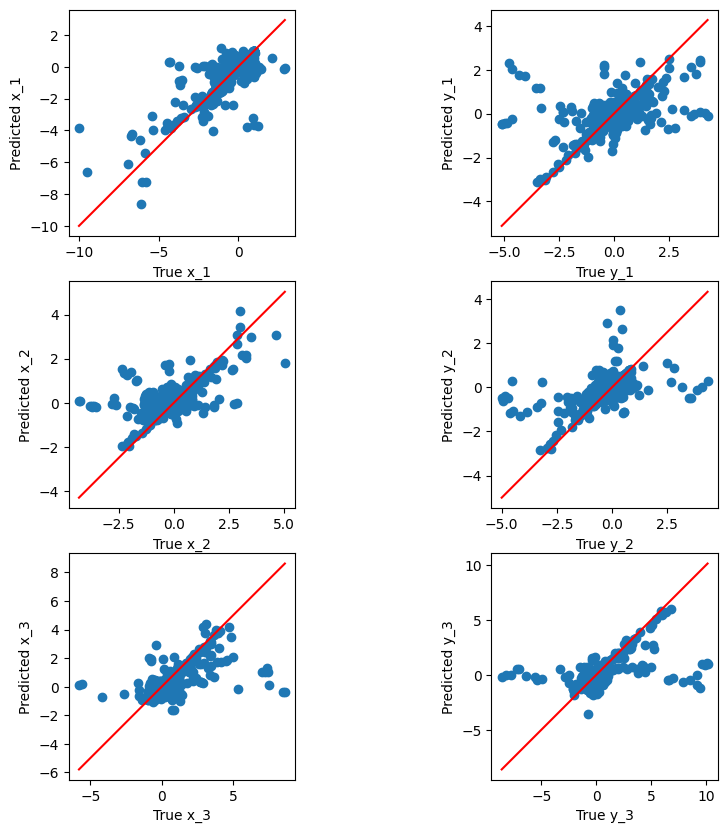

In [208]:
plot_y_yhat(y_val, y_val_pred, 'teste')

# Kaggle Submission

In [227]:
X_test_submision = pd.read_csv("X_test.csv")
X_test_submision.columns = ['Id', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
id= X_test_submision[['Id']]
X_test_kaggle = X_test_submision.drop('Id', axis = 1)
X_test_kaggle = feature_relative_angle(X_test_kaggle)
X_test_kaggle = feature_relative_angle_2(X_test_kaggle)
X_test_kaggle = feature_relative_angle_3(X_test_kaggle)
X_test_kaggle = distance_between_points(X_test_kaggle)
X_test_kaggle = centroid(X_test_kaggle)
# Treino for kaggle
X_train_kaggle = X[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', "t"]]
X_train_kaggle = feature_relative_angle(X_train_kaggle)
X_train_kaggle = feature_relative_angle_2(X_train_kaggle)
X_train_kaggle = feature_relative_angle_3(X_train_kaggle)
X_train_kaggle = distance_between_points(X_train_kaggle)
X_train_kaggle = centroid(X_train_kaggle)
y_train_kaggle = y[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

scale = Normalizer()

regressor.fit(scale.fit_transform(X_train_kaggle[columns]), y_train_kaggle)
y_pred_kaggle = regressor.predict(scale.fit_transform(X_test_kaggle[columns]))

submission = pd.DataFrame(y_pred_kaggle, columns= ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'])

pd.concat([id, submission],axis = 1).to_csv(r'Submissions/GradientBoost.csv', index = False)

C:\Users\victtor.moraes\AppData\Local\Temp\ipykernel_2152\2674574981.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['angle_1_2_3'] = np.arccos(np.clip(cos_theta, -1.0, 1.0))
